In [56]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [57]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES
from math import pi as PI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore hyperparameter tuning for site-specific xgb models

Site specific linear regression models performs better than single-xgb for the stations with higher numbers of samples. <br>
<u>This is the case even if we have site-specific xgb models with shared hyperparameter.</u><br>
Since a single xgb makes prediction for all stations, the model might not be using optimal hyperparameter in terms of the number of samples.<br>
From now on, we test:
### If we have site-specific xgb models with different hyperparameters (that are obtained via hyperparameter tuning), can xgb outperform linear regression?

RMSE using site-specific Linear Regression models: 4.098
RMSE using a sigle XGBost model: 3.998



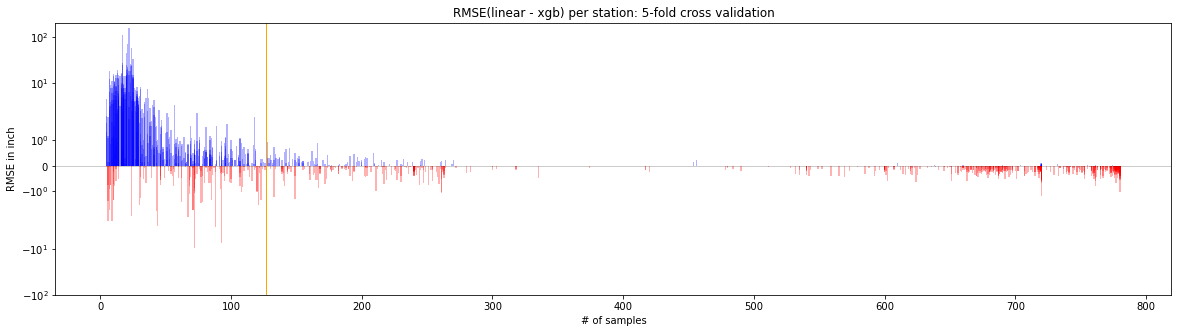

In [4]:
df_result = pd.read_csv(f"{BASE_DIR}/SiteSpecific/result.csv")

rmse_per_station_linear = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False))
rmse_per_station_xgb = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_single_xgb'], squared=False))
n_data = df_result.groupby(by="skn").size()
df_rmse = pd.DataFrame({"n_data": n_data, "rmse_linear": rmse_per_station_linear, "rmse_xgb": rmse_per_station_xgb})
df_rmse['diff'] = df_rmse['rmse_linear'] - df_rmse['rmse_xgb']

rmse_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_linear'], squared=False)
rmse_xgb = mean_squared_error(df_result['data_in'], df_result['prediction_single_xgb'], squared=False)

print("RMSE using site-specific Linear Regression models: {:.3f}".format(rmse_linear))
print("RMSE using a sigle XGBost model: {:.3f}".format(rmse_xgb))

# df_stats = df_combined.groupby('skn').size().reset_index().rename(columns={0:"n_data"}).groupby("n_data").size().reset_index().rename(columns={0: "n_stations"})

fig, ax = plt.subplots(1, figsize=(20,5))
ax.bar(
    x=df_rmse['n_data'],
    height=df_rmse['diff'],
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_rmse['diff']],
    alpha=0.3
)


ax.set_ylim((-100, 200))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_xlabel('# of samples')
ax.set_ylabel('RMSE in inch')
# ax.axhline(y=100, linewidth=1, linestyle='--')
    
ax.set_title("RMSE(linear - xgb) per station: 5-fold cross validation")
ax.set(yscale='symlog')
# plt.tight_layout()

# ax.scatter(df_stats['n_data'], df_stats['n_stations'], s=1, c='k', marker='x')
print()

## Hyperparameter Tuning

In [58]:
# Split the stations by the number of samples available
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

# skn selsction:
1. Split the entire data into two: everything 2007 (inclusive) and everything after 2007 (exclusive)
2. select the stations which exist both on the test set and the training set, AND which have more than 400 training set.

In [59]:
# prepare held-out test set: any data after 2007 (exclusive)
df_train_original = df_combined[df_combined['year'] <= 2007]
df_test_original = df_combined[df_combined['year'] > 2007]

In [60]:
intersection = set(df_test_original['skn'].unique()).intersection(set(df_train_original['skn'].unique()))
df_intersection_skn = pd.DataFrame(intersection, columns={"skn"})

df_train_intersection = df_train_original.merge(right=df_intersection_skn, left_on='skn', right_on='skn')
df_test_intersection = df_test_original.merge(right=df_intersection_skn, left_on='skn', right_on='skn')

In [61]:
threshold = 400
df_train_intersection_skn = df_train_intersection.groupby('skn').size().reset_index().rename(columns={0: "n_samples"})
df_train_intersection_skn_high_samples = df_train_intersection_skn[df_train_intersection_skn["n_samples"] > threshold]
df_train = df_train_intersection.merge(right=df_train_intersection_skn_high_samples, left_on='skn', right_on='skn')
df_test = df_test_intersection.merge(right=df_train_intersection_skn_high_samples, left_on='skn', right_on='skn')

In [62]:
a = set(df_train['skn'].unique())
b = set(df_test['skn'].unique())
assert len(a - b) == 0
assert len(b - a) == 0

In [77]:
# hyperparameter tuning:
# for a specific parameter, get site-specific predictions using cross_val_predict

In [75]:
df_skn_samples = pd.DataFrame(np.random.choice(df_train['skn'].unique(), size=10), columns={"skn"})
df_train_samples = df_train.merge(right=df_skn_samples, left_on='skn', right_on='skn')

In [86]:
parameters = [
    sherpa.Choice('n_estimators', list(range(100, 310, 10))),
    sherpa.Choice('early_stopping_rounds', list(range(10))),
    sherpa.Choice('learning_rate', [0.05, 0.1, 0.5, 1.0, 1.25, 1.5, 2]),
    sherpa.Discrete('max_depth', [1, 10]),
]


alg = sherpa.algorithms.RandomSearch(max_num_trials=1)
study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://10.100.11.206:8884 if on a cluster or
http://localhost:8884 if running locally.
-------------------------------------------------------


 * Serving Flask app 'sherpa.app.app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [87]:
# def report(message, report_time=False, start=None):
#     with open(FILE_NAME, 'a') as f:
#         f.write(message + '\n')
#         if report_time:
#             curr = time.time()
#             f.write("Elapsed time: {:.2f}\n".format(curr - start))
            
n_folds = 5
for trial in study:
    # set up the hyperparameters
    start = time.time()
    line = '===============================================\n'
    params = {
        "n_estimators": trial.parameters['n_estimators'],
        "learning_rate": trial.parameters['learning_rate'],
        "max_depth": trial.parameters['max_depth'],
        "early_stopping_rounds": trial.parameters['early_stopping_rounds'],
        "verbosity": 1
    }
    
    print(params)
    line += str(params) + '\n'
    
    # stations with low number of samples
    y_true = []
    y_pred = []
    for name, group in df_train_samples.groupby('skn'):
        line = ''
        group.sort_values(by=["year", "month"], inplace=True)
        
        X = np.array(group[columns])
        Y = np.array(group['data_in'])
        
        kf = KFold(n_splits=5)
        for temp_index, test_index in kf.split(X):
            train_index, valid_index = train_test_split(temp_index, test_size=0.2, shuffle=False)
            Xtrain, Xvalid, Xtest = X[train_index], X[valid_index], X[test_index]
            Ytrain, Yvalid, Ytest = Y[train_index], Y[valid_index], Y[test_index]
            
            model = XGBRegressor(**params)
            model.fit(Xtrain, Ytrain, eval_set=[(Xvalid, Yvalid)])
        
        continue

        
        y_true.extend(Y)
        y_pred.extend(cross_val_predict(model, X, Y, cv=n_folds, n_jobs=-1))
    #rmse = mean_squared_error(y_true, y_pred, squared = False)
    #line += f"RMSE: {rmse}\n"
    
    study.add_observation(
        trial=trial,
        iteration=1,
        objective=rmse,
        # context={'rmse_high': rmse_high}
    )

    study.finalize(trial)

# print(study.get_best_result())

{'n_estimators': 190, 'learning_rate': 0.5, 'max_depth': 8, 'early_stopping_rounds': 4, 'verbosity': 1}
[144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364

NameError: name 'rmse' is not defined

In [81]:
print(line)

RMSE on low number of samples: 11.206173688731738

[01:37:11] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:37:14] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:37:17] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then bein